In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn, basic
from lenskit import topn

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)
ratings.head()

,user,item,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item', 'title', 'genre'], header=0)
items.head()

,item,title,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
items_dummy = pd.concat([items, items['genre'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genre,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
joined = ratings.join(items_dummy.set_index('item'), on='item')

joined


,user,item,rating,timestamp,title,genre,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1263,2.0,1260759151,"Deer Hunter, The (1978)",Drama|War,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,1287,2.0,1260759187,Ben-Hur (1959),Action|Adventure|Drama,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1293,2.0,1260759148,Gandhi (1982),Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
9,1,1343,2.0,1260759131,Cape Fear (1991),Thriller,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [8]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [14]:
all_recs = []
test_data = []
for train, test in xf.partition_users(joined[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
    

test _reccomend
test _reccomend


In [15]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genre,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,117192,5.250000,1,1,ItemItem,Doctor Who: The Time of the Doctor (2013),(no genres listed),1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,98491,5.214286,1,2,ItemItem,Paperman (2012),Animation|Comedy|Romance,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,136016,5.000000,1,3,ItemItem,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,8199,4.885292,1,4,ItemItem,Ugetsu (Ugetsu monogatari) (1953),Drama|Thriller,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,71108,4.824324,1,5,ItemItem,"White Ribbon, The (Das weiße Band) (2009)",Drama|Mystery,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,1172,4.0
1,1,2455,2.5
2,1,1029,3.0
3,1,1287,2.0
4,2,509,4.0


In [22]:
rla = topn.RecListAnalysis(['user', 'Algorithm'])
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs_joined, test_data)
results.head()

ndcg
user Algorithm          
1    ALS        0.000000
     ItemItem   0.000000
2    ALS        0.048742
     ItemItem   0.000000
3    ALS        0.000000

In [23]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.065669
ItemItem    0.004373
Name: ndcg, dtype: float64

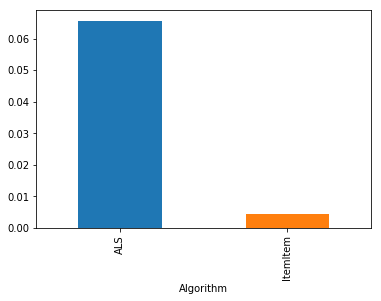

In [24]:
results.groupby('Algorithm').ndcg.mean().plot.bar()